In [1]:
%pylab inline
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read(file):
    with open(file) as f:
        t, F, h = [], [], []
        for sor in f: # így iterálhatunk végig egy adatfolyamon vagy file-on
            if sor[0]!='%': # file-ban lévő komment kiszedése
                t.append( float(sor.split()[0]) )
                F.append( float(sor.split()[1]) )
                h.append( float(sor.split()[2]) )
            
    return t, F, h

def lin(x, a, b):
    return a*x + b

def fig(f, H, param, name):
    X = linspace(0, max(H)+0.1, 100)
    plot(H, f, 'bo', markersize = 1, label = 'adatok')
    plot(X, lin(X, *param), color = 'orange', label = 'fit')
    ylim(0, max(f)+10)
    xlabel(r'h[$\mu$m]', fontsize = 15)
    ylabel('F[mN]', fontsize = 15)
    legend()
    savefig(name)
    
def HapCi(f, H, x1):
    x2 = max(H)
    x = []
    y = []
    for i in range(len(H)):
        if i >= H.index(max(H)): # a tényleges hmaxtól vannak elemek
            x.append(H[i])
            y.append(f[i])
        
    x = array(x)
    y = array(y)
    popt,pcov=curve_fit(lin, x[(x>x1)*(x<x2)], y[(x>x1)*(x<x2)]) # az illesztés elvégzése a kijelölt részre
    perr = sqrt(diag(pcov))
    print('egyenes: a, b +- err\n', popt, '+-', perr)
    
    #s = lin(H[f.index(max(f))], *popt)
    #HC = H[f.index(max(f))] - 0.75 * max(f) / s
    HC = -1 * popt[1]/popt[0] # tengelymetszet
    s = (0.75*max(f)) / (H[f.index(max(f))] - HC)
    
    return popt, perr, s, HC
    
def Young(f, H, x1, nu, name):
    a, b, S, hc = HapCi(f, H, x1)
    fig(f, H, a, name)
    
    #dS = sqrt((b[0]*H[f.index(max(f))])**2 + (a[0]*dh)**2 + (b[1])**2)
    #dhc = sqrt(dh**2 + 0.75**2 * ((dF/S)**2 + (dS*max(f)/(S**2)))**2)
    
    A  = 24.5*hc**2
    #dA = abs(24.5*2*hc*dhc)
    Er = sqrt(pi/A) * S / (2*beta)
    #dEr = (sqrt(pi)/(2*beta)) * sqrt((dS/sqrt(A))**2 + (0.5*S*dA/(A**(3/2)))**2)
    E = (1 - nu**2) / ((1/Er) - ((1 - nui**2)/Ei))
    #dE = abs((1/Er**2) * dEr * (1-nu**2) / ((1/Er) - ((1 - nui**2)/Ei))**2)
    
    return E#, dEr

def kem(f, H, x1, name):
    a, b, S, hc = HapCi(f, H, x1)
    #dS = sqrt((b[0]*H[f.index(max(f))])**2 + (a[0]*dh)**2 + (b[1])**2)
    #dhc = sqrt(dh**2 + 0.75**2 * ((dF/S)**2 + (dS*max(f)/(S**2)))**2)
    fig(f, H, a, name)
    Hv = max(f) / (24.5*hc**2)
    #dHv = sqrt((dF/(24.5*hc**2))**2 + (2*max(f)*dhc/(24.5*hc**3))**2)
    print('HV =', Hv)
    return Hv#, dHv

def konc(x, a, b, n):
    return a + b*x**n

def konc_ill(x, y, ye):
    x = array(x)
    y = array(y)
    ye = array(ye)
    popt, pcov = curve_fit(konc, x, y, sigma = ye)
    perr = sqrt(diag(pcov))
    print('a, b, n')
    print(popt, '+-', perr)
    
    X = linspace(0, max(x)+0.02, 100)
    errorbar(100*x, y, yerr = ye, fmt = 'bo', markersize = 1, label = 'adatok')
    plot(100*X, konc(X, *popt), color = 'orange', label = 'fit')
    xlabel('cc[%]', fontsize = 15)
    ylabel('HV[GPa]', fontsize = 15)
    legend()
    savefig('konc.png')
    
def plasz(x, k, alpha):
    return k*(x**alpha)

def plasz_ill(x, y, name):
    xp = []
    yp = []
    for i in range(len(x)):
        if x[i] >= 0:
            yp.append(y[i])
            xp.append(x[i])
    X = linspace(0, max(xp) + 0.1, 100)
    popt, pcov = curve_fit(plasz, xp, yp)
    perr = sqrt(diag(pcov))
    print('k, alpha')
    print(popt, '+-', perr)
    
    plot(x, y, 'bo', markersize = 1, label = 'adatok')
    plot(X, plasz(X, *popt), color = 'orange', label = 'fit')
    xlabel(r'h[$\mu$m]', fontsize = 15)
    ylabel('F[mN]', fontsize = 15)
    legend()
    savefig(name)
    
    F = interp1d(X, plasz(X, *popt), bounds_error = False, fill_value = "extrapolate")
    delta = []
    for j in range(len(yp)):
        delta.append(yp[j] - F(xp[j]))
        
    return xp,delta

In [3]:
Ei = 1070 #GPa
nui = 0.17
#dh = 0.01
#dF = 0.02
beta = 1.012

irodalmi E értékek GPa-ban: $E_{Fe} = 211$, $E_{Ag} = 83$, $E_{Al} = 70$, $E_{Cu} = 130$, $E_{Ni} = 200$

(1.03, 1.1)

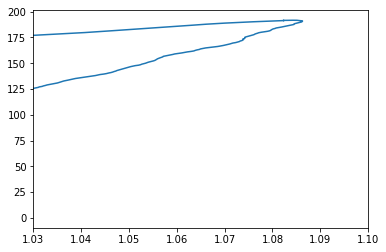

In [4]:
t_Fe1, F_Fe1, h_Fe1 = read('2020_marc11_Fe_1.dat')
plot(h_Fe1, F_Fe1)
xlim(1.03, 1.1)

egyenes: a, b +- err
 [ 1156.14374482 -1065.72209321] +- [32.7411519  35.48115386]
E_Fe1 = 185.25452926788648 +- GPa


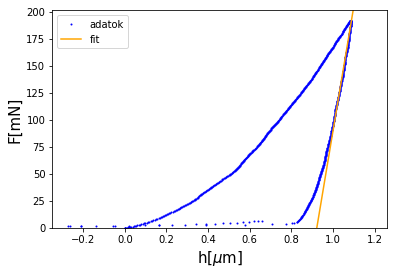

In [5]:
E_Fe1 = Young(F_Fe1, h_Fe1, 1.08, 0.28, 'E_Fe1.png')
print('E_Fe1 =', E_Fe1, '+-', 'GPa')

(1.1, 1.15)

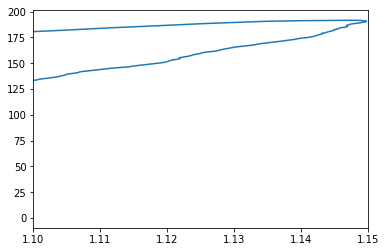

In [6]:
t_Fe2, F_Fe2, h_Fe2 = read('2020_marc11_Fe_2.dat')
plot(h_Fe2, F_Fe2)
xlim(1.1, 1.15)

egyenes: a, b +- err
 [ 1219.89706488 -1214.09382523] +- [25.762989  29.3596951]
E_Fe2 = 182.06392609624277 +- GPa
E_Fe = 183.65922768206462 +- 1.5953015858218578 GPa


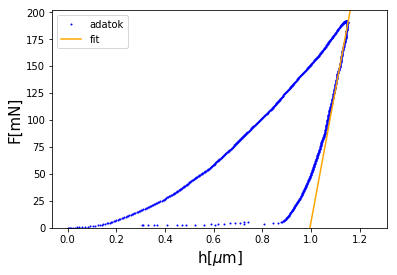

In [7]:
E_Fe2 = Young(F_Fe2, h_Fe2, 1.125, 0.28, 'E_Fe2.png')
print('E_Fe2 =', E_Fe2, '+-', 'GPa')

E_Fe = (E_Fe1 + E_Fe2)/2
E_Feerr = max([abs(E_Fe - E_Fe1), abs(E_Fe - E_Fe2)])#, 0.5*sqrt(dE_Fe1**2+dE_Fe2**2)])
print('E_Fe =', E_Fe, '+-', E_Feerr, 'GPa')

(2.7, 2.875)

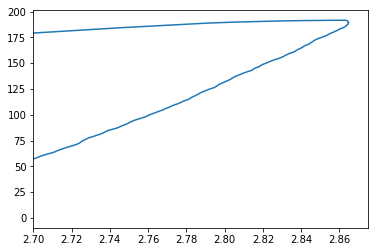

In [8]:
t_Ag1, F_Ag1, h_Ag1 = read('2020_marc11_pure_Ag_1.dat')
plot(h_Ag1, F_Ag1)
xlim(2.7, 2.875)

egyenes: a, b +- err
 [  856.55524871 -2267.00810053] +- [3.24258855 9.19216089]
E_Ag1 = 40.70122047553925 +- GPa


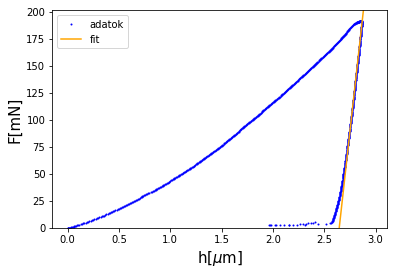

In [9]:
E_Ag1 = Young(F_Ag1, h_Ag1, 2.8, 0.35, 'E_Ag1.png')
print('E_Ag1 =', E_Ag1, '+-', 'GPa')

(2.55, 2.66)

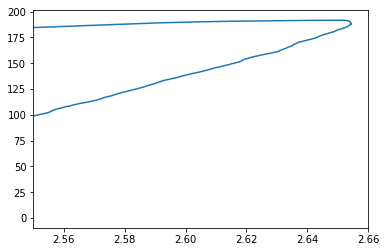

In [10]:
t_Ag2, F_Ag2, h_Ag2 = read('2020_marc11_pure_Ag_2.dat')
plot(h_Ag2, F_Ag2)
xlim(2.55, 2.66)

egyenes: a, b +- err
 [  906.696397   -2221.17773825] +- [ 6.45708682 16.98198956]
E_Ag2 = 48.09099722612625 +- GPa
E_Ag = 44.396108850832746 +- 3.694888375293502 GPa


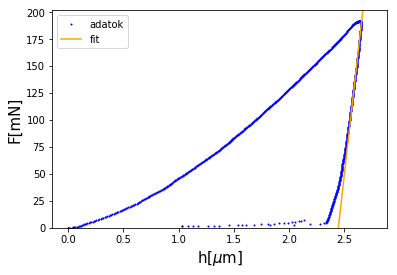

In [11]:
E_Ag2 = Young(F_Ag2, h_Ag2, 2.6, 0.35, 'E_Ag2.png')
print('E_Ag2 =', E_Ag2, '+-', 'GPa')

E_Ag = (E_Ag1 + E_Ag2)/2
E_Agerr = max([abs(E_Ag - E_Ag1), abs(E_Ag - E_Ag2)])#, 0.5*sqrt(dE_Ag1**2+dE_Ag2**2)])
print('E_Ag =', E_Ag, '+-', E_Agerr, 'GPa')

(5.4, 5.475)

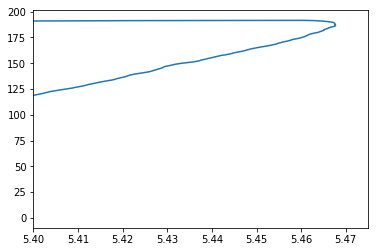

In [12]:
t_Al1, F_Al1, h_Al1 = read('2020_marc11_pure_Al_1.dat')
plot(h_Al1, F_Al1)
xlim(5.4, 5.475)

egyenes: a, b +- err
 [ 1092.67614588 -5790.01035079] +- [14.27156479 77.85991821]
E_Al1 = 27.19893990731248 +- GPa


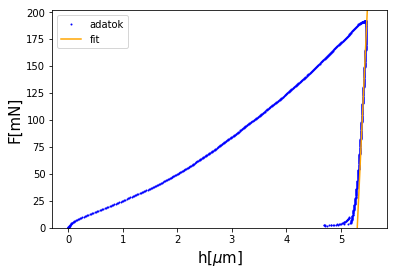

In [13]:
E_Al1 = Young(F_Al1, h_Al1, 5.44, 0.35, 'E_Al1.png')
print('E_Al1 =', E_Al1, '+-', 'GPa')

(5.25, 5.33)

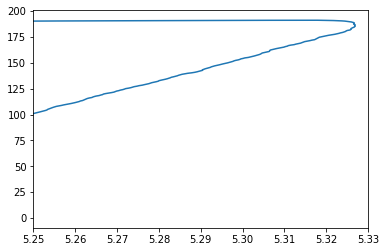

In [14]:
t_Al2, F_Al2, h_Al2 = read('2020_marc11_pure_Al_2.dat')
plot(h_Al2, F_Al2)
xlim(5.25, 5.33)

egyenes: a, b +- err
 [ 1094.89786785 -5648.81960275] +- [ 8.24796432 43.83140738]
E_Al2 = 27.96397955148571 +- GPa
E_Al = 27.581459729399093 +- 0.3825198220866177 GPa


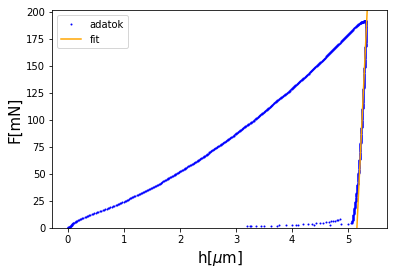

In [15]:
E_Al2 = Young(F_Al2, h_Al2, 5.3, 0.35, 'E_Al2.png')
print('E_Al2 =', E_Al2, '+-', 'GPa')

E_Al = (E_Al1 + E_Al2)/2
E_Alerr = max([abs(E_Al - E_Al1), abs(E_Al - E_Al2)])#, 0.5*sqrt(dE_Al1**2+dE_Al2**2)])
print('E_Al =', E_Al, '+-', E_Alerr, 'GPa')

(2.1, 2.17)

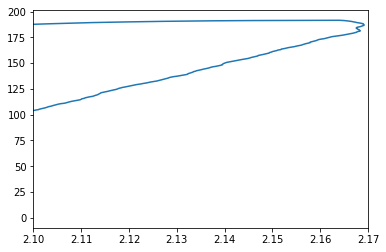

In [16]:
t_Cu1, F_Cu1, h_Cu1 = read('2020_marc11_pure_Cu_1.dat')
plot(h_Cu1, F_Cu1)
xlim(2.1, 2.17)

egyenes: a, b +- err
 [ 1188.40225123 -2394.08935332] +- [13.86326332 29.89531638]
E_Cu1 = 80.659840493378 +- GPa


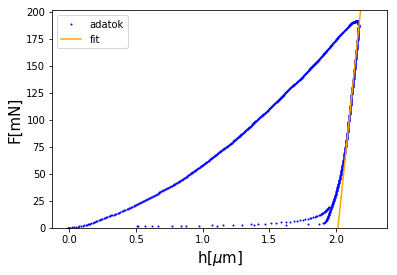

In [17]:
E_Cu1 = Young(F_Cu1, h_Cu1, 2.14, 0.35, 'E_Cu1.png')
print('E_Cu1 =', E_Cu1, '+-', 'GPa')

(2.05, 2.15)

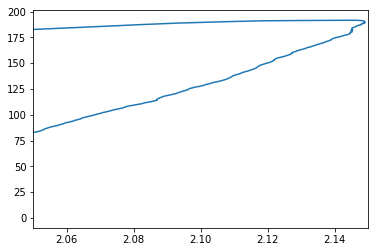

In [18]:
t_Cu2, F_Cu2, h_Cu2 = read('2020_marc11_pure_Cu_2.dat')
plot(h_Cu2, F_Cu2)
xlim(2.05, 2.15)

egyenes: a, b +- err
 [ 1277.79818363 -2558.97845544] +- [17.10332541 36.53579742]
E_Cu2 = 84.61574565124305 +- GPa
E_Cu = 82.63779307231053 +- 1.9779525789325305 GPa


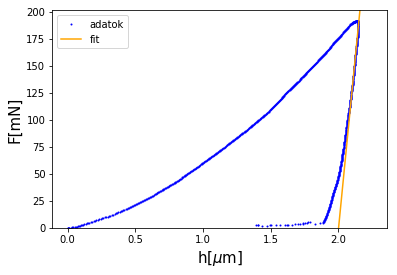

In [19]:
E_Cu2 = Young(F_Cu2, h_Cu2, 2.12, 0.35, 'E_Cu2.png')
print('E_Cu2 =', E_Cu2, '+-', 'GPa')

E_Cu = (E_Cu1 + E_Cu2)/2
E_Cuerr = max([abs(E_Cu - E_Cu1), abs(E_Cu - E_Cu2)])#, 0.5*sqrt(dE_Cu1**2 + dE_Cu2**2)])
print('E_Cu =', E_Cu, '+-', E_Cuerr, 'GPa')

(1.58, 1.62)

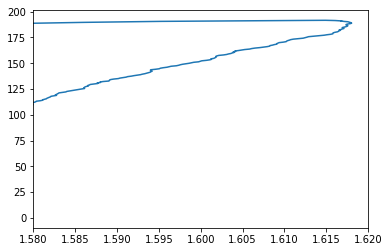

In [20]:
t_Ni1, F_Ni1, h_Ni1 = read('2020_marc11_pure_Ni_1.dat')
plot(h_Ni1, F_Ni1)
xlim(1.58, 1.62)

egyenes: a, b +- err
 [ 1818.36859565 -2756.80938129] +- [26.29852714 42.33823985]
E_Ni1 = 182.8231971258906 +- GPa


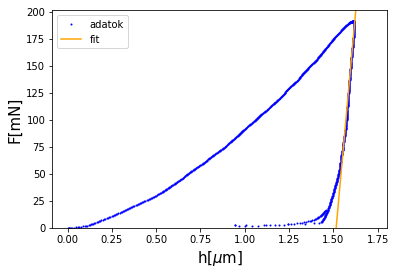

In [21]:
E_Ni1 = Young(F_Ni1, h_Ni1, 1.6, 0.3, 'E_Ni1.png')
print('E_Ni1 =', E_Ni1, '+-', 'GPa')

(1.45, 1.53)

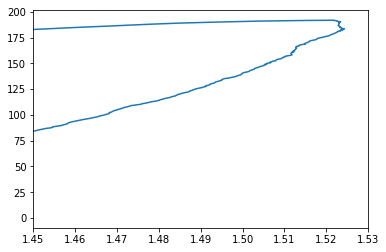

In [22]:
t_Ni2, F_Ni2, h_Ni2 = read('2020_marc11_pure_Ni_2.dat')
plot(h_Ni2, F_Ni2)
xlim(1.45, 1.53)

egyenes: a, b +- err
 [ 1616.54492295 -2282.391855  ] +- [14.12200766 21.23755883]
E_Ni2 = 177.43277082406132 GPa
E_Ni = 180.12798397497596 +- 2.6952131509146398 GPa


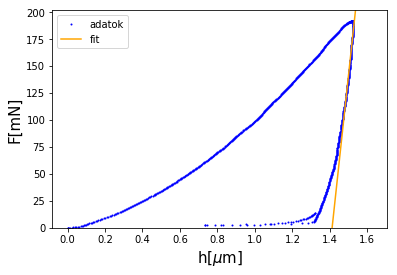

In [23]:
E_Ni2 = Young(F_Ni2, h_Ni2, 1.48, 0.3, 'E_Ni2.png')
print('E_Ni2 =', E_Ni2,  'GPa')

E_Ni = (E_Ni1 + E_Ni2)/2
E_Nierr = max([abs(E_Ni - E_Ni1), abs(E_Ni - E_Ni2)])#, 0.5*sqrt(dE_Ni1**2+dE_Ni2**2)])
print('E_Ni =', E_Ni, '+-', E_Nierr, 'GPa')

egyenes: a, b +- err
 [ 1092.67614588 -5790.01035079] +- [14.27156479 77.85991821]
HV = 0.2786239487646796


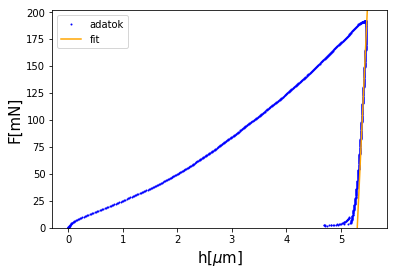

In [24]:
HV1_0 = kem(F_Al1, h_Al1, 5.44, 'HV1_0.png')

egyenes: a, b +- err
 [ 1094.89786785 -5648.81960275] +- [ 8.24796432 43.83140738]
HV = 0.2931399150261269
HV_0 = 0.28588193189540323 +- 0.0072579831307236775


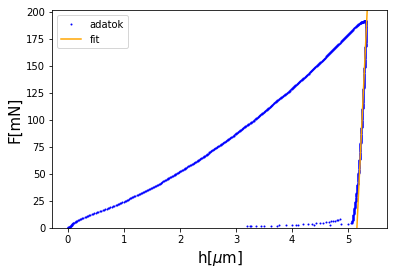

In [66]:
HV2_0 = kem(F_Al2, h_Al2, 5.3, 'HV2_0.png')

HV_0 = (HV1_0 + HV2_0) / 2
HV_0err = max([abs(HV1_0 - HV_0), abs(HV_0 - HV2_0)])#, 0.5*sqrt(dHV1_27**2+dHV2_27**2)])

print('HV_0 =', HV_0, '+-', HV_0err)

(4, 4.13)

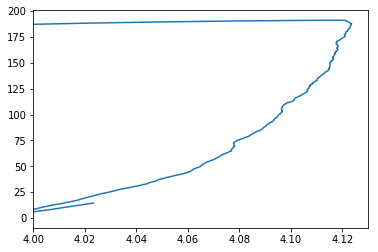

In [26]:
t1_047, F1_047, h1_047 = read('2020_marc11_Al_047Mg_1.dat')
plot(h1_047, F1_047)
xlim(4, 4.13)

egyenes: a, b +- err
 [  3803.18445902 -15495.52605823] +- [134.24591267 553.20004362]
HV = 0.47004517126783607


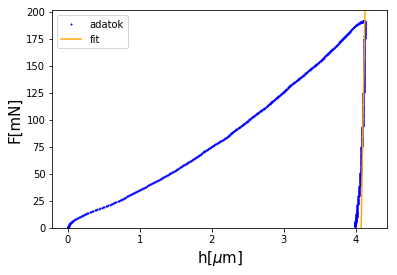

In [27]:
HV1_047 = kem(F1_047, h1_047, 4.118, 'HV1_047.png')

(4.2, 4.4)

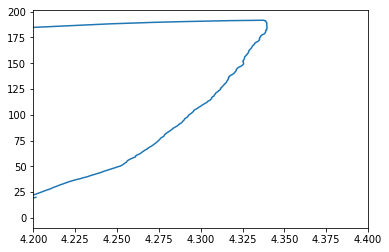

In [28]:
t2_047, F2_047, h2_047 = read('2020_marc11_Al_047Mg_2.dat')
plot(h2_047, F2_047)
xlim(4.2, 4.4)

egyenes: a, b +- err
 [ 2154.1352226 -9164.5265222] +- [ 34.67660379 150.2050408 ]
HV = 0.43210657202944075
HV_047 = 0.4510758716486384 +- 0.018969299619197688


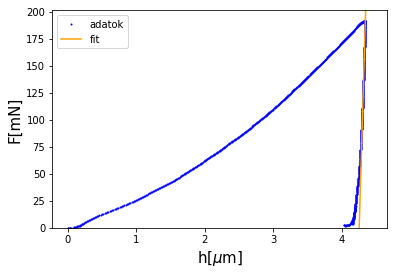

In [29]:
HV2_047 = kem(F2_047, h2_047, 4.325, 'HV2_047.png')

HV_047 = (HV1_047 + HV2_047) / 2
HV_047err = max([abs(HV1_047 - HV_047), abs(HV2_047 - HV2_047)])#, 0.5*sqrt(dHV1_047**2+dHV2_047**2)])

print('HV_047 =', HV_047, '+-', HV_047err)

(3.8, 3.92)

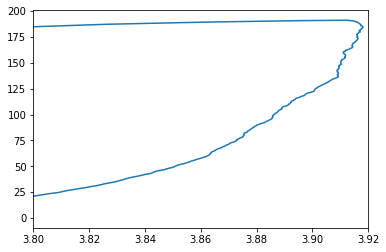

In [30]:
t1_093, F1_093, h1_093 = read('2020_marc11_Al_093Mg_1.dat')
plot(h1_093, F1_093)
xlim(3.8, 3.92)

egyenes: a, b +- err
 [  4105.62480696 -15902.77068886] +- [103.76798217 406.14152542]
HV = 0.520046818830257


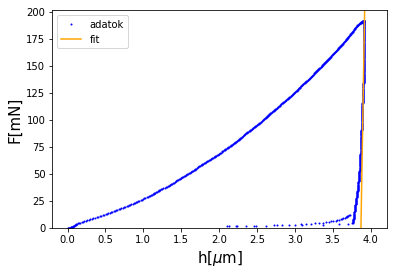

In [31]:
HV1_093 = kem(F1_093, h1_093, 3.91, 'HV1_093.png')

(3.6, 3.71)

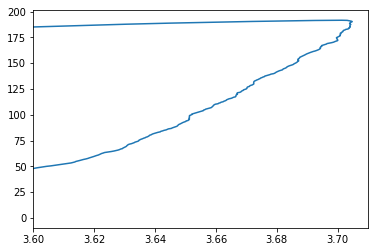

In [32]:
t2_093, F2_093, h2_093 = read('2020_marc11_Al_093Mg_2.dat')
plot(h2_093, F2_093)
xlim(3.6, 3.71)

egyenes: a, b +- err
 [ 1866.52304271 -6729.24774071] +- [25.7205694  95.02247904]
HV = 0.6016564779285077
HV_093 = 0.5608516483793824 +- 0.04080482954912534


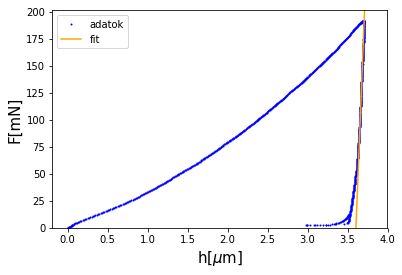

In [33]:
HV2_093 = kem(F2_093, h2_093, 3.68, 'HV2_093.png')

HV_093 = (HV1_093 + HV2_093) / 2
HV_093err = max([abs(HV1_093 - HV_093), abs(HV2_093 - HV2_093)])#, 0.5*sqrt(dHV1_093**2+dHV2_093**2)])

print('HV_093 =', HV_093, '+-', HV_093err)

(3.5, 3.59)

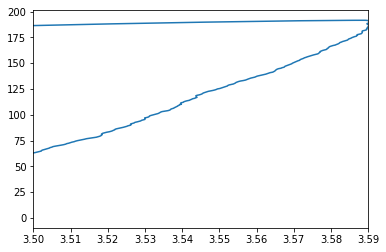

In [34]:
t1_125, F1_125, h1_125 = read('2020_marc11_Al_125Mg_1.dat')
plot(h1_125, F1_125)
xlim(3.5, 3.59)

egyenes: a, b +- err
 [ 1773.05479311 -6181.04490422] +- [ 30.46357143 109.13361276]
HV = 0.643470190312388


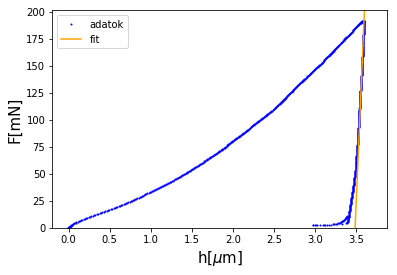

In [35]:
HV1_125 = kem(F1_125, h1_125, 3.57, 'HV1_125.png')

(3.5, 3.67)

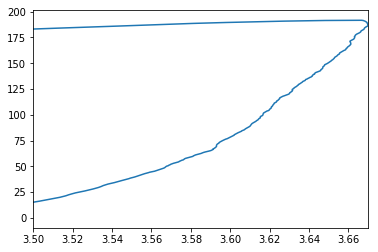

In [36]:
t2_125, F2_125, h2_125 = read('2020_marc11_Al_125Mg_2.dat')
plot(h2_125, F2_125)
xlim(3.5, 3.67)

egyenes: a, b +- err
 [ 1626.30777466 -5783.78597466] +- [12.73313191 46.49184315]
HV = 0.6186095939455231
HV_125 = 0.6310398921289555 +- 0.012430298183432442


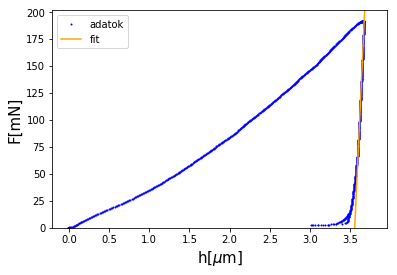

In [37]:
HV2_125 = kem(F2_125, h2_125, 3.63, 'HV2_125.png')

HV_125 = (HV1_125 + HV2_125) / 2
HV_125err = max([abs(HV1_125 - HV_125), abs(HV2_125 - HV2_125)])#, 0.5*sqrt(dHV1_125**2+dHV2_125**2)])

print('HV_125 =', HV_125, '+-', HV_125err)

(3.3, 3.45)

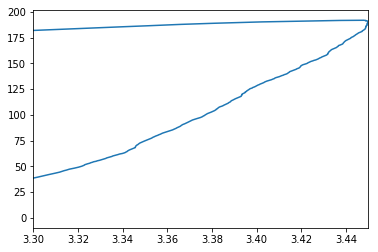

In [38]:
t1_145, F1_145, h1_145 = read('2020_marc11_Al_145Mg_1.dat')
plot(h1_145, F1_145)
xlim(3.3, 3.45)

egyenes: a, b +- err
 [ 1407.55961293 -4669.77817118] +- [18.21645503 62.63445672]
HV = 0.7111569409536328


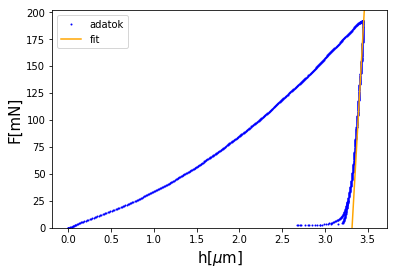

In [39]:
HV1_145 = kem(F1_145, h1_145, 3.42, 'HV1_145.png')

(3.38, 3.495)

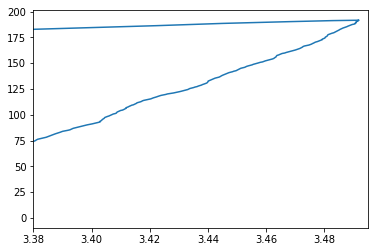

In [40]:
t2_145, F2_145, h2_145 = read('2020_marc11_Al_145Mg_2.dat')
plot(h2_145, F2_145)
xlim(3.38, 3.495)

egyenes: a, b +- err
 [ 1227.69286228 -4096.72713984] +- [11.43512647 39.77533351]
HV = 0.7022324289857974
HV_145 = 0.7066946849697151 +- 0.004462255983917696


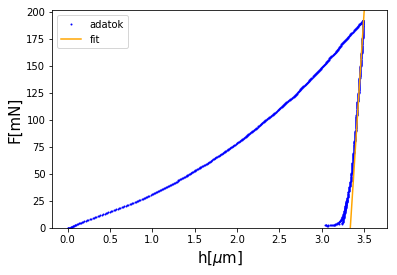

In [41]:
HV2_145 = kem(F2_145, h2_145, 3.46, 'HV2_145.png')

HV_145 = (HV1_145 + HV2_145) / 2
HV_145err = max([abs(HV1_145 - HV_145), abs(HV2_145 - HV2_145)])#, 0.5*sqrt(dHV1_145**2+dHV2_145**2)])

print('HV_145 =', HV_145, '+-', HV_145err)

(3.4, 3.535)

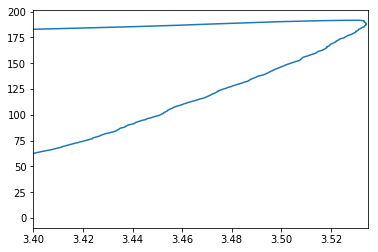

In [42]:
t1_2, F1_2, h1_2 = read('2020_marc11_Al_2Mg_1.dat')
plot(h1_2, F1_2)
xlim(3.4, 3.535)

egyenes: a, b +- err
 [ 1205.48571999 -4074.71523043] +- [10.07909206 35.46995802]
HV = 0.6849077336647849


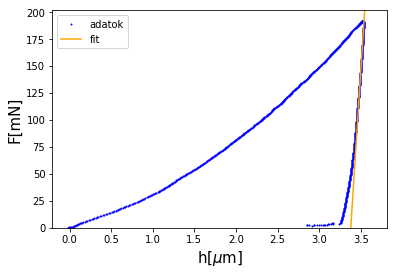

In [43]:
HV1_2 = kem(F1_2, h1_2, 3.5, 'HV1_2.png')

(3.4, 3.57)

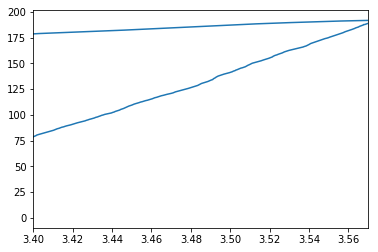

In [44]:
t2_2, F2_2, h2_2 = read('2020_marc11_Al_2Mg_2.dat')
plot(h2_2, F2_2)
xlim(3.4, 3.57)

egyenes: a, b +- err
 [  553.77807734 -1796.58804963] +- [ 3.42928496 11.76483072]
HV = 0.7438422439567978
HV_2 = 0.7143749888107913 +- 0.029467255146006455


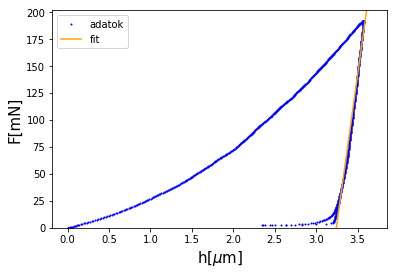

In [45]:
HV2_2 = kem(F2_2, h2_2, 3.25, 'HV2_2.png')

HV_2 = (HV1_2 + HV2_2) / 2
HV_2err = max([abs(HV1_2 - HV_2), abs(HV2_2 - HV2_2)])#, 0.5*sqrt(dHV1_2**2+dHV2_2**2)])

print('HV_2 =', HV_2, '+-', HV_2err)

(2.95, 3.07)

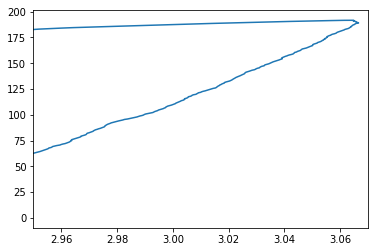

In [46]:
t1_27, F1_27, h1_27 = read('2020_marc11_Al_27Mg_1.dat')
plot(h1_27, F1_27)
xlim(2.95, 3.07)

egyenes: a, b +- err
 [ 1275.77189177 -3723.07132632] +- [ 8.61034043 26.29528519]
HV = 0.91865899988871


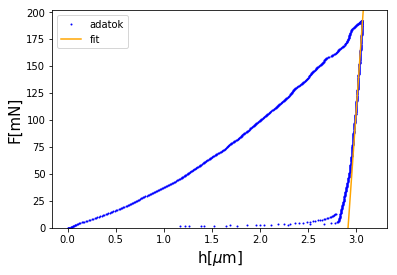

In [47]:
HV1_27 = kem(F1_27, h1_27, 3.04, 'HV1_27.png')

(2.95, 3.03)

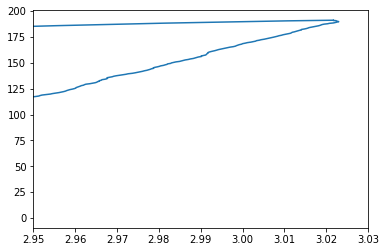

In [48]:
t2_27, F2_27, h2_27 = read('2020_marc11_Al_27Mg_2.dat')
plot(h2_27, F2_27)
xlim(2.95, 3.03)

egyenes: a, b +- err
 [  996.33263389 -2821.34428555] +- [11.11944948 33.51439133]
HV = 0.973259288395409
HV_27 = 0.9459591441420595 +- 0.02730014425334948


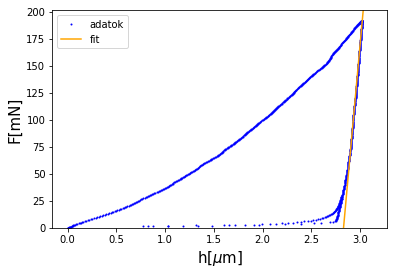

In [49]:
HV2_27 = kem(F2_27, h2_27, 3.005, 'HV2_27.png')

HV_27 = (HV1_27 + HV2_27) / 2
HV_27err = max([abs(HV1_27 - HV_27), abs(HV2_27 - HV2_27)])#, 0.5*sqrt(dHV1_27**2+dHV2_27**2)])

print('HV_27 =', HV_27, '+-', HV_27err)

(2.95, 3.015)

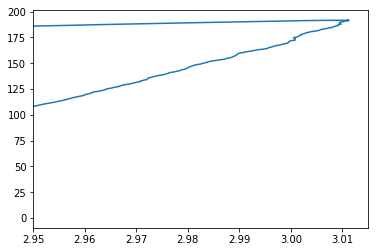

In [50]:
t1_45, F1_45, h1_45 = read('2020_marc11_Al_45Mg_1.dat')
plot(h1_45, F1_45)
xlim(2.95, 3.015)

egyenes: a, b +- err
 [ 1715.00635618 -4972.54371298] +- [ 34.15922591 102.6387727 ]
HV = 0.9309123160879812


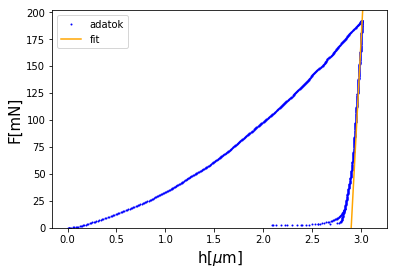

In [51]:
HV1_45 = kem(F1_45, h1_45, 2.997, 'HV1_45.png')

(2.6, 2.9)

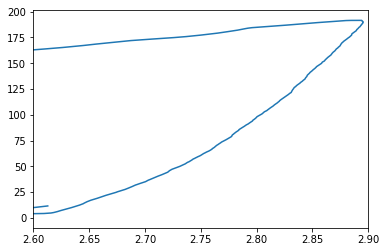

In [52]:
t2_45, F2_45, h2_45 = read('2020_marc11_Al_45Mg_2.dat')
plot(h2_45, F2_45)
xlim(2.6, 2.9)

egyenes: a, b +- err
 [ 1015.22564453 -2751.34703733] +- [2.97649994 8.53889543]
HV = 1.0649021111384915
HV_45 = 0.9979072136132363 +- 0.06699489752525511


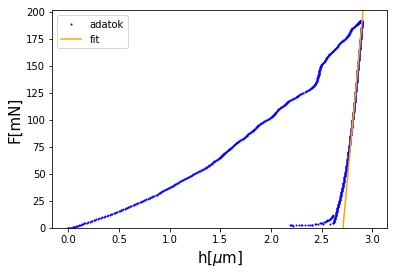

In [53]:
HV2_45 = kem(F2_45, h2_45, 2.84, 'HV2_45.png')

HV_45 = (HV1_45 + HV2_45) / 2
HV_45err = max([abs(HV1_45 - HV_45), abs(HV2_45 - HV2_45)])#, 0.5*sqrt(dHV1_45**2+dHV2_45**2)])

print('HV_45 =', HV_45, '+-', HV_45err)

(2.6, 2.77)

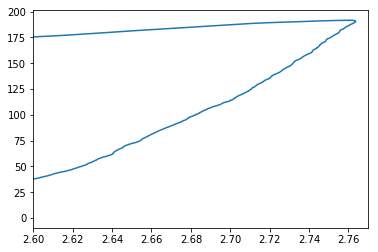

In [54]:
t1_73, F1_73, h1_73 = read('2020_marc11_Al_73Mg_1.dat')
plot(h1_73, F1_73)
xlim(2.6, 2.77)

egyenes: a, b +- err
 [ 1301.79711936 -3406.63496249] +- [ 6.55552775 18.00757998]
HV = 1.1423069910174788


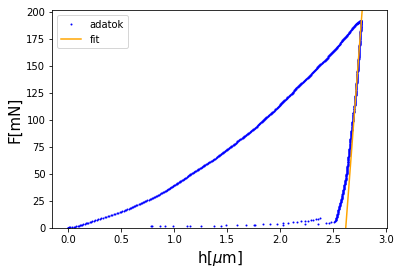

In [55]:
HV1_73 = kem(F1_73, h1_73, 2.73, 'HV1_73.png')

(2.57, 2.67)

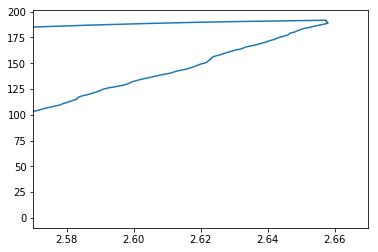

In [56]:
t2_73, F2_73, h2_73 = read('2020_marc11_Al_73Mg_2.dat')
plot(h2_73, F2_73)
xlim(2.57, 2.67)

egyenes: a, b +- err
 [ 1008.20813432 -2489.94863054] +- [10.11511517 26.74747409]
HV = 1.2826711183383783
HV_73 = 1.2124890546779286 +- 0.07018206366044977


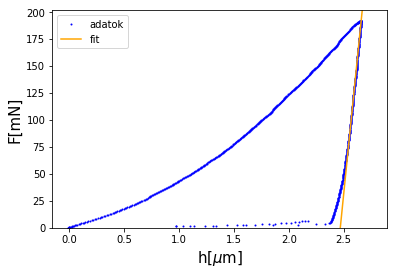

In [57]:
HV2_73 = kem(F2_73, h2_73, 2.63, 'HV2_73.png')

HV_73 = (HV1_73 + HV2_73) / 2
HV_73err = max([abs(HV1_73 - HV_73), abs(HV2_73 - HV2_73)])#, 0.5*sqrt(dHV1_73**2+dHV2_73**2)])

print('HV_73 =', HV_73, '+-', HV_73err)

In [67]:
HV = [HV_0, HV_047, HV_093, HV_125, HV_145, HV_2, HV_27, HV_45, HV_73]
HVerr = [HV_0err, HV_047err, HV_093err, HV_125err, HV_145err, HV_2err, HV_27err, HV_45err, HV_73err]
cc = [0, 0.0047, 0.0093, 0.0125, 0.0145, 0.02, 0.027, 0.045, 0.073]

/home/friss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in power


a, b, n
[0.28347095 4.92587529 0.58392761] +- [0.01743411 1.47174725 0.07337934]


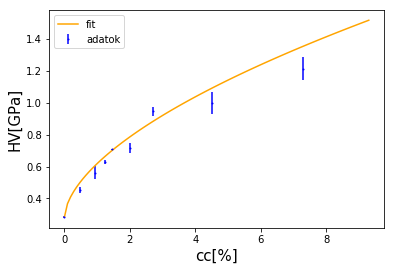

In [68]:
konc_ill(cc, HV, HVerr)

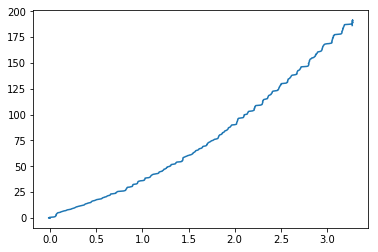

In [60]:
t_v05, F_v05, h_v05 = read('2020_marc11_Al_2Mg_v05.dat')
plot(h_v05, F_v05)

k, alpha
[33.76022003  1.45402843] +- [0.03244959 0.00095481]


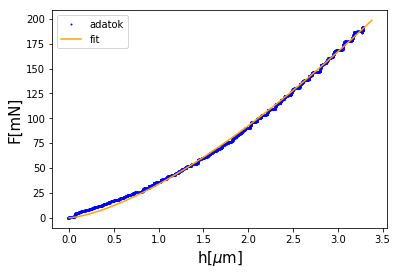

In [61]:
hp_v05, dF_v05 = plasz_ill(h_v05, F_v05, 'v05.png')

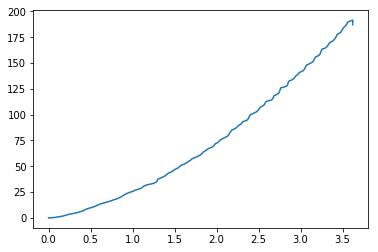

In [62]:
t_v2, F_v2, h_v2 = read('2020_marc11_Al_2Mg_v2.dat')
plot(h_v2, F_v2)

In [63]:
h_v2m = []
F_v2m = []
for j in range(len(h_v2)):
    if j <= F_v2.index(max(F_v2)):
        h_v2m.append(h_v2[j])
        F_v2m.append(F_v2[j])

k, alpha
[23.7785138   1.62346763] +- [0.02665876 0.00101286]


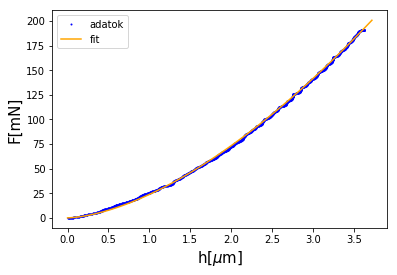

In [64]:
hp_v2, dF_v2 = plasz_ill(h_v2m, F_v2m, 'v2.png')

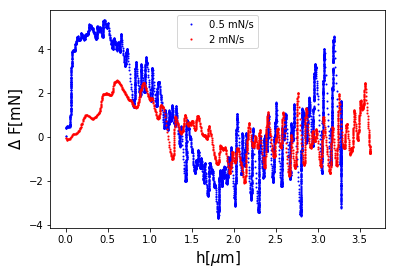

In [65]:
plot(hp_v05, dF_v05, 'bo', linestyle = '', markersize = 1, label = '0.5 mN/s')
plot(hp_v2, dF_v2, 'rs', linestyle = '', markersize = 1, label = '2 mN/s')
ylabel(r'$\Delta$ F[mN]', fontsize = 15)
xlabel(r'h[$\mu$m]', fontsize = 15)
legend(loc = 9)
savefig('deltaF.png')